In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection and splitting data 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Evaluation metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Pickel
import pickle
import json

#Overfitting
from sklearn.linear_model import Ridge,Lasso

#Hyperparameter Tunning 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#Future Warnings

#### 1) Problem Statement

In [ ]:
Predict medical insurance price/ premium base on independent features

#### 2) Data Gathering

In [81]:
df = pd.read_csv("medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 3) EDA

##### 3.1 Missing

In [82]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [83]:
df.isna().mean()

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [84]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


##### 3.2 Outliers Detection

<Axes: >

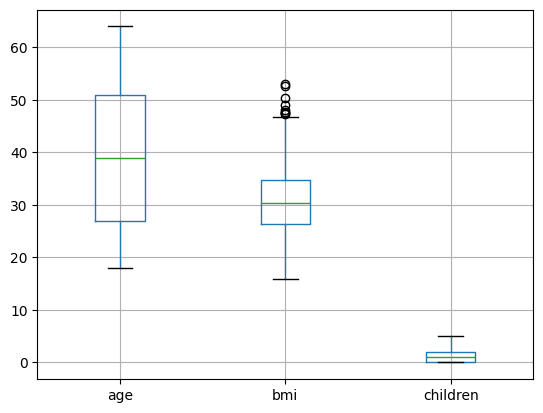

In [85]:
df[["age","bmi","children"]].boxplot()

<Axes: xlabel='bmi'>

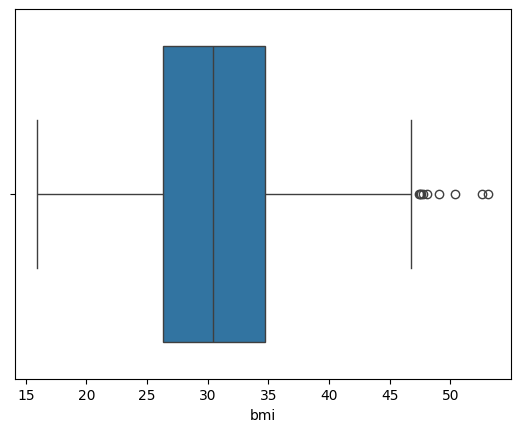

In [86]:
sns.boxplot(df["bmi"],orient="h")

##### Detecting Outliers using IQR method

In [87]:
q1 = df["bmi"].quantile(0.25)
q2 = df["bmi"].quantile(0.5)
q3 = df["bmi"].quantile(0.75)
iqr = q3 - q1
print(iqr)
upper_tail = q3 + 1.5*iqr
print(upper_tail)
df.loc[(df["bmi"]>upper_tail)]

8.3975
47.290000000000006


,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


##### Detecting Outliers using z_score method

In [88]:
mean = np.mean(df["bmi"])
std = np.std(df["bmi"])
threshold = 2.7
outliers = []
for x_val in df["bmi"]:
    z_score = (x_val - mean) / std
    if z_score > threshold:
        outliers.append(x_val)
outliers

[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]

In [89]:
df["sex"].unique()

array(['female', 'male'], dtype=object)

In [90]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

##### vif

In [91]:
df1 = df.drop(["charges","sex","smoker","region"],axis=1)
x_constant= sm.add_constant(df1)
vif_list = [variance_inflation_factor(x_constant.values,i) for i in range(x_constant.shape[1])]
s1 = pd.Series(vif_list,index = x_constant.columns)
s1

const       31.954929
age          1.013816
bmi          1.012152
children     1.001874
dtype: float64

<Axes: >

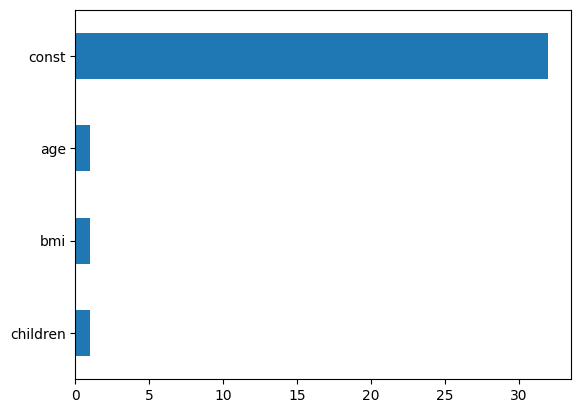

In [92]:
s1 = pd.Series(vif_list,index = x_constant.columns)
s1.sort_values().plot(kind="barh")

##### Corr()

In [93]:
df1.corr()

,age,bmi,children
age,1.000000,0.109272,0.042469
bmi,0.109272,1.000000,0.012759
children,0.042469,0.012759,1.000000


#### 4) Feature Engineering

In [ ]:
# treament of missing > .fillna()
# outliers >> either transformation or imputation
# rename

In [94]:
df.rename(columns = {"sex" : "gender"},inplace=True)

In [95]:
df.head()

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [96]:
df["gender"].replace({"male" : 0,"female" : 1},inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\9806732.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["gender"].replace({"male" : 0,"female" : 1},inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\9806732.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["gender"].replac

In [97]:
df["gender"].value_counts()

gender
0    676
1    662
Name: count, dtype: int64

In [98]:
df["smoker"].replace({"no":0,"yes":1},inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\1034743619.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["smoker"].replace({"no":0,"yes":1},inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\1034743619.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["smoker"].replace({

In [99]:
df["smoker"].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

#### encoding

In [100]:
df.head()

,age,gender,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


In [101]:
df = pd.get_dummies(df, columns=["region"],dtype=float)
df.head()

,age,gender,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


#### 5) feature selection

In [102]:
df.corr()

,age,gender,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
gender,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.057292,0.002425,0.011156,-0.017117,0.004184
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.198341,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,0.002425,-0.138156,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,0.011156,-0.135996,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,-0.017117,0.270025,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


In [104]:
x_constant= sm.add_constant(df1)
vif_list = [variance_inflation_factor(x_constant.values,i) for i in range(x_constant.shape[1])]
s1 = pd.Series(vif_list,index = x_constant.columns)
s1

const       31.954929
age          1.013816
bmi          1.012152
children     1.001874
dtype: float64

<Axes: >

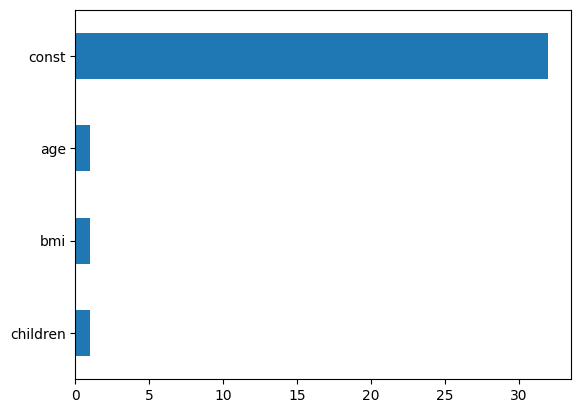

In [105]:
s1 = pd.Series(vif_list,index = x_constant.columns)
s1.sort_values().plot(kind="barh")

#### 6) Data Spliting

In [107]:
x = df.drop("charges",axis=1)
y = df["charges"]

In [108]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=43)

#### 7) Model Selection

In [109]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)

LinearRegression()

#### 8) Model Evaluation

##### 8.1) On testing Data

In [114]:
y_pred_test  = lr_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 43001715.78797236
mean absolue error
 4475.477852500109
r2 score is  0.6942989522010103
adjusted r2 score 0.6836349621615108


##### 8.2) On Training Data

In [113]:
y_pred_train = lr_model.predict(x_train) #y_train
mse = mean_squared_error(y_train,y_pred_train)
print("Mean Squared error is",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("Mean Absolute Error is",mae)

r2 = r2_score(y_train,y_pred_train)
print("R2 square is",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

Mean Squared error is 34954953.93224392
Mean Absolute Error is 4021.792780562888
R2 square is 0.7635971854041862
adjusted r2 score 0.7615899916953538


#### 1) Ridge

In [115]:
ridge_model = Ridge(alpha=1.0)  #  alpha=1. = lambda
ridge_model.fit(x_train,y_train)

Ridge()

In [116]:
# On testing data
y_pre_test = ridge_model.predict(x_test)  #y_test
mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error is",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("Mean absolute error is",mae)

r2 = r2_score(y_test,y_pred_test)
print("R squared error is",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("Adjusted r2 score is",adj_r2)

Mean squared error is 43001715.78797236
Mean absolute error is 4475.477852500109
R squared error is 0.6942989522010103
Adjusted r2 score is 0.6836349621615108


In [117]:
# on training data
y_pred_train = ridge_model.predict(x_train) #y_train
mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error is",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("Mean absolute error is",mae)

r2 = r2_score(y_train,y_pred_train)
print("R2 score is",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("Adjusted r2 score is",adj_r2)

Mean squared error is 34958038.658040315
Mean absolute error is 4031.0011934933914
R2 score is 0.7635763231864319
Adjusted r2 score is 0.761568952345562


#### 2) Lasso

In [118]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(x_train,y_train)

Lasso()

In [119]:
# on testing data
y_pred_test = lasso_model.predict(x_test)  #y_test
mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error is",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("Mean absolute error is",mae)

r2 = r2_score(y_test,y_pred_test)
print("R2 score is",r2)

adj_r2 = 1- (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("Adjusted r2 score is",adj_r2)

Mean squared error is 42998201.72551685
Mean absolute error is 4475.551482041851
R2 score is 0.6943239338222084
Adjusted r2 score is 0.683660815234611


In [120]:
# on training data
y_pred_train = lasso_model.predict(x_train) #y_train
mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error is",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("Mean absolute error is",mae)

r2 = r2_score(y_train,y_pred_train)
print("R2 score is",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("Adjusted r2 score is",adj_r2)

Mean squared error is 34954981.73259768
Mean absolute error is 4021.939554728524
R2 score is 0.7635969973884362
Adjusted r2 score is 0.7615898020832437


#### Check slope of the feature selection

In [121]:
lasso_model.coef_

array([  255.47853444,  -121.29195606,   324.71798767,   494.90704134,
       23954.75770722,   803.43428771,   472.98592532,    -0.        ,
        -281.41348284])

<Axes: >

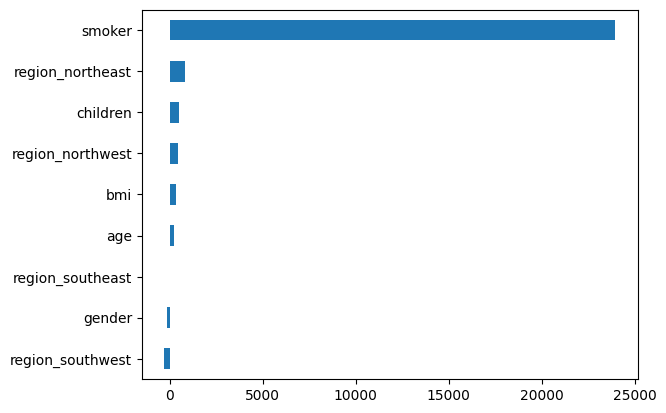

In [122]:
s1 = pd.Series(lasso_model.coef_,index=x.columns)
s1.sort_values().plot(kind="barh")

In [ ]:
# conclusion : gender has 0 slope therefore we can drop

In [123]:
x_train1 = x_train.drop("gender",axis=1)
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(x_train1,y_train)

Lasso()

In [124]:
# On testing data
x_test1 =  x_test.drop("gender",axis=1)
y_pred_test  = lasso_model.predict(x_test1) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test1.shape[0]-1))/(x_test1.shape[0]-x_test1.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 42922458.32216923
mean absolue error
 4474.046339945579
r2 score is  0.6948623969356664
adjusted r2 score 0.6854372972271157


In [ ]:
# ridge and lasso no change in MSE OR R2

#### HyperParameter Tunning

In [ ]:
# alpha = lambda  =1.0 default

In [126]:
np.arange(0.01,3,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

##### 1) GridSearchCV on Ridge model

In [127]:
estimator_ridge = Ridge()
parameter_grid = {"alpha":np.arange(0.01,3,0.01)}
gdsearchCV = GridSearchCV(estimator=estimator_ridge,param_grid=parameter_grid,cv=5)
gdsearchCV.fit(x_train,y_train)
gdsearchCV.best_estimator_

Ridge(alpha=1.84)

In [128]:
# on testing data
ridge_model = gdsearchCV.best_estimator_   #alpha =1.84
y_pred_test = ridge_model.predict(x_test) #y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 42959434.12983182
mean absolue error
 4494.118098390439
r2 score is  0.6945995343280114
adjusted r2 score 0.6839460297115466


In [129]:
# on training data
ridge_model = gdsearchCV.best_estimator_  #alpha = 1.84
y_pred_train  = ridge_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34965296.53384512
mean absolue error
 4038.7149230655737
r2 score is  0.7635272376613425
adjusted r2 score 0.7615194500565803


##### 2) RandomaizedsearchCV on Ridge Model

In [130]:
estimator_ridge = Ridge()
parameter_grid = {"alpha" :np.arange(0.01,3,0.01)}
rdsearchCV = RandomizedSearchCV(estimator_ridge,parameter_grid,cv=5)
rdsearchCV.fit(x_train,y_train)
rdsearchCV.best_estimator_

Ridge(alpha=1.9000000000000001)

In [131]:
# on testing data
ridge_model = rdsearchCV.best_estimator_  #alpha = 1.900000
y_test_pred = ridge_model.predict(x_test)  #y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 42959434.12983182
mean absolue error
 4494.118098390439
r2 score is  0.6945995343280114
adjusted r2 score 0.6839460297115466


In [132]:
# on training data
ridge_model = rdsearchCV.best_estimator_   #1.900000
y_pred_train = ridge_model.predict(x_train)  #y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34965974.413031876
mean absolue error
 4039.272306220106
r2 score is  0.7635226531166734
adjusted r2 score 0.761514826586532


#### 1) GridsearchCv on Lasso Model

In [133]:
estimator_lasso = Lasso()
parameter_grid = {"alpha":np.arange(0.01,3,0.01)}
gdsearchCv = GridSearchCV(estimator=estimator_lasso,param_grid=parameter_grid,cv=5)
gdsearchCv.fit(x_train,y_train)
gdsearchCv.best_estimator_

Lasso(alpha=2.9899999999999998)

In [134]:
# on testing data
lasso_model = gdsearchCv.best_estimator_    #alpha = 2.98
y_pred_test = lasso_model.predict(x_test)  #y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 42991379.556689315
mean absolue error
 4475.734281019019
r2 score is  0.6943724329139451
adjusted r2 score 0.6837110061551293


In [135]:
# on training data
lasso_model = gdsearchCv.best_estimator_   #alpha = 2.98
y_pred_train = lasso_model.predict(x_train)   #y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34955202.539067194
mean absolue error
 4022.23194755971
r2 score is  0.7635955040587361
adjusted r2 score 0.7615882960743292


#### Final Model Selected based on of MSE and R2 score

In [136]:
# lr_model
with open("Linear_model.pkl","wb") as file:
    pickle.dump(lr_model,file)

In [139]:
project_data = {"gender" : {"male":0,"female":1},
                 "smoker": {"yes":1,"no":0},
                  "columns":list(x.columns)}
project_data

{'gender': {'male': 0, 'female': 1},
 'smoker': {'yes': 1, 'no': 0},
 'columns': ['age',
  'gender',
  'bmi',
  'children',
  'smoker',
  'region_northeast',
  'region_northwest',
  'region_southeast',
  'region_southwest']}

In [140]:
with open("project_data.json","w") as file:
    json.dump(project_data,file)

In [141]:
x.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [144]:
with open("Linear_model.pkl","rb") as file:
    model = pickle.load(file)

In [145]:
with open("project_data.json","r") as file:
    project_data = json.load(file)    

In [152]:
# Input from user
age = 19
gender = "female"
bmi = 45
children = 2
smoker = "yes"
region = "southeast"
# charges = ?

In [146]:
column_names = project_data["columns"]
column_names

['age',
 'gender',
 'bmi',
 'children',
 'smoker',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [166]:
column_names = project_data["columns"]
array1 = np.array(column_names)
test_array = np.zeros(len(column_names))
test_array[0] = age
test_array[1] = project_data["gender"][gender]
test_array[2] = bmi
test_array[3] = children
test_array[4] = project_data["smoker"][smoker]
region1 = "region_" + region
print(region1)  #region_southeast
index = np.where(array1 == region1)
index
test_array[index] = 1
test_array

region_southeast


array([19.,  1., 45.,  2.,  1.,  0.,  0.,  1.,  0.])

In [168]:
premium_price = model.predict([test_array])[0]
print("Final predicted price is",premium_price)

Final predicted price is 31805.24861525184


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
